The following notebook implements the MOSAIKs model to predict temperature from satelleiete imagery in New York City.

In [ ]:
import os
os.kill(os.getpid(), 9)


In [ ]:
import sys
print(sys.executable)

/usr/bin/python3


In [ ]:
!nvidia-smi

In [12]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/My Drive/MOSAIKS/Explore-Satellite-Feature-Extraction-for-/"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['1st_MOSAIKS temperature prediction for NYC.ipynb',
 'conx-3.7.10',
 'hyperlocal temperature monitering with nta.csv',
 'conx-3.7.10.tar.gz.3',
 'conx-3.7.10.tar.gz',
 'conx-3.7.10.tar.gz.4',
 'conx-3.7.10.tar.gz.2',
 'conx-3.7.10.tar.gz.5',
 'conx-3.7.10.tar.gz.1',
 'LICENSE',
 'Distritos.prj',
 'Distritos.shp',
 'Distritos.shx',
 'Distritos.sbx',
 'README.md',
 'Distritos.sbn',
 'Distritos.dbf',
 'spatial_joined_data',
 '.ipynb_checkpoints',
 '.git',
 'NYC.shx',
 'NYC.cpg',
 'NYC.shp',
 'NYC.qmd',
 'NYC.dbf',
 'NYC.prj',
 'T18TWK_20231221T155651_TCI_10m.tif',
 'nyc_satellite_image.png',
 'Fetching Satellite image of NYC.ipynb',
 'tile_1.png',
 'tile_2.png',
 'tile_3.png',
 'tile_4.png',
 'tile_5.png',
 'tile_6.png',
 'tile_7.png',
 'tile_8.png',
 'tile_9.png',
 'tile_10.png',
 'tile_11.png',
 'tile_12.png',
 'tile_13.png',
 'tile_14.png',
 'tile_15.png',
 'tile_16.png',
 'tile_17.png',
 'tile300step_0.png',
 'tile_0.png',
 'sentinel-2-l2a-example.ipynb',
 'T18TWK_20190801T153911_TCI

In [4]:
!pip install torch

!pip install numpy pandas matplotlib

!pip install torchviz

In [5]:
!pip install geopandas rasterio dask-geopandas scikit-learn scipy pystac-client planetary-computer contextily dask

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 21.8 MB/s eta 0:00:00


In [6]:
!git clone https://github.com/milesgranger/gap_statistic.git
%cd gap_statistic
!pip install -r requirements.txt
!python setup.py install



fatal: destination path 'gap_statistic' already exists and is not an empty directory.
/content/drive/MyDrive/MOSAIKS/Explore-Satellite-Feature-Extraction-for-/gap_statistic
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/dist.py:261: UserWarning: Unknown distribution option: 'tests_require'
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/d

In [7]:
!pip install "dask[distributed]" --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.10.0
    Uninstalling dask-2024.10.0:
      Successfully uninstalled dask-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.1.16 requires dask==2024.10.0, but you have dask 2024.12.1 which is incompatible.


In [8]:
# Read in packages
import warnings
import time
import os

RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry
import geopandas as gdp
import dask_geopandas
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from dask.distributed import Client as DaskClient
from pystac_client import Client as StacClient
import pystac_client
import planetary_computer as pc
import contextily as cx
import geopandas as gpd
from sklearn.cluster import KMeans
from shapely import wkt
from sklearn.preprocessing import robust_scale
warnings.filterwarnings(action="ignore", category=LinAlgWarning, module="sklearn")
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from shapely.geometry import shape
from shapely.geometry import Point, box

import gap_statistic
import gap_statistic


warnings.filterwarnings("ignore")


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


### Data Preparation

In [13]:
# Read in shapefile of Madrid with district boundaries
db = gpd.read_file('NYC.shp')
# Set local crs in m
db = db.to_crs(32618)

In [14]:
# Initialize grid_list
grid_list = []


# Create grids to patch image
# Change the step size to change sizes
# Set the initial CRS and step size
crs = '32618'
initial_step = 100
final_step = 400
step_increase = 100


# Loop through step sizes
for STEP in range(initial_step, final_step + 1, step_increase):
    # Total bounds of the original GeoDataFrame (assuming it's called db)
    a, b, c, d = db.total_bounds

    # Create a grid for geometry
    gdf_grid = gpd.GeoDataFrame(
        geometry=[
            shapely.geometry.box(minx, miny, maxx, maxy)
            for minx, maxx in zip(np.arange(a, c, STEP), np.arange(a, c, STEP)[1:])
            for miny, maxy in zip(np.arange(b, d, STEP), np.arange(b, d, STEP)[1:])
        ],
        crs=crs,
    ).to_crs(db.crs)

    # Append the current GeoDataFrame to the list
    grid_list.append(gdf_grid)


In [15]:
grid_list[0]

,geometry
0,"POLYGON ((563143.767 4483076.377, 563143.767 4..."
1,"POLYGON ((563143.767 4483176.377, 563143.767 4..."
2,"POLYGON ((563143.767 4483276.377, 563143.767 4..."
3,"POLYGON ((563143.767 4483376.377, 563143.767 4..."
4,"POLYGON ((563143.767 4483476.377, 563143.767 4..."
...,...
218549,"POLYGON ((609643.767 4529476.377, 609643.767 4..."
218550,"POLYGON ((609643.767 4529576.377, 609643.767 4..."
218551,"POLYGON ((609643.767 4529676.377, 609643.767 4..."
218552,"POLYGON ((609643.767 4529776.377, 609643.767 4..."


In [16]:
len(grid_list)

4

In [17]:
for i in range(4):
  print(len(grid_list[i]))

218554
54522
24180
13572


\# Calculate the Green and blue ratio

In [18]:
from rasterio.mask import mask
import shapely.geometry

In [19]:
import os
import pickle
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
from joblib import Parallel, delayed

def convert_crs(gdf_grid, target_crs, index):
    print(f"Converting CRS for grid {index + 1}...")
    converted_grid = gdf_grid.to_crs(target_crs)
    print(f"CRS conversion completed for grid {index + 1}.")
    return converted_grid

def process_cell(raster_path, row, row_index, index):
    try:
        with rasterio.open(raster_path) as src:
            geom = [row.geometry]
            out_image, out_transform = mask(src, geom, crop=True)
            out_image = out_image[0]  # Assuming single band raster

            # Calculate green and blue space ratios
            total_pixels = out_image.size
            green_pixels = np.sum((out_image == 1) | (out_image == 2))
            blue_pixels = np.sum(out_image == 4)

            if total_pixels > 0:
                green_ratio = green_pixels / total_pixels
                blue_ratio = blue_pixels / total_pixels
            else:
                green_ratio = 0
                blue_ratio = 0

            # Calculate building area ratio using land cover class (5) Buildings
            building_pixels = np.sum(out_image == 5)
            building_area_ratio = building_pixels / total_pixels if total_pixels > 0 else 0

    except Exception as e:
        print(f"Error processing cell {row_index + 1} in grid {index + 1}: {e}")
        green_ratio = None
        blue_ratio = None
        building_area_ratio = None

    return green_ratio, blue_ratio, building_area_ratio

def calculate_ratios_and_building_area(raster_path, grid, index, start_row=0, batch_size=100):
    print(f"Processing grid {index + 1}...")

    num_rows = len(grid)
    output_file = os.path.join('finer1/ratio_final_results', f'grid_{index + 1}_final.pkl')

    # Load existing results if available
    if os.path.exists(output_file):
        with open(output_file, 'rb') as f:
            results = pickle.load(f)
        print(f"Loaded existing results for grid {index + 1} from {output_file}")
    else:
        results = []

    # Continue from start_row
    for start in range(start_row, num_rows, batch_size):
        end = min(start + batch_size, num_rows)

        # Reprocess the current batch
        batch_results = reprocess_batch(raster_path, grid.iloc[start:end], start, end, index)
        results.extend(batch_results)

        # Save the updated results after processing the batch
        with open(output_file, 'wb') as f:
            pickle.dump(results, f)

        # Save or append the batch results to the CSV
        csv_filename = f'finer/green_blue_building_area_ratio_df{index + 1}_final.csv'
        df_to_save = grid.iloc[start:end].copy()
        df_to_save['green_ratio'] = [res[0] for res in batch_results]
        df_to_save['blue_ratio'] = [res[1] for res in batch_results]
        df_to_save['building_area_ratio'] = [res[2] for res in batch_results]

        # Append the results to the CSV file (writing header only if start == 0)
        df_to_save.to_csv(csv_filename, mode='a', header=(start == 0 and start_row == 0), index=False)

        print(f"Saved CSV: {csv_filename} with rows {start} to {end}")

        # Print progress
        print(f"Processed rows {start} to {end} for grid {index + 1}. Total processed: {end} of {num_rows}")

    print(f"Completed processing for grid {index + 1}. Results saved to {output_file}.")
    return grid

def reprocess_batch(raster_path, grid_slice, start, end, index):
    print(f"Reprocessing batch {start} to {end} for grid {index + 1}...")
    batch_results = Parallel(n_jobs=-1)(
        delayed(process_cell)(raster_path, row, row_index, index)
        for row_index, row in grid_slice.iterrows()
    )
    return batch_results

def determine_start_row(pkl_filename):
    if os.path.exists(pkl_filename):
        with open(pkl_filename, 'rb') as f:
            results = pickle.load(f)
            return len(results)  # Number of entries in the pickle file
    return 0

def load_previous_results_and_continue(raster_path, grid_list, start_index=0, batch_size=100):
    # Extract the CRS from the raster
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs

    results_list = []  # Initialize an empty list to store the results of each grid

    for index, gdf_grid in enumerate(grid_list):
        if index < start_index:
            continue  # Skip grids before the starting index

        print(f"Starting processing for grid {index + 1}...")

        # Convert CRS
        converted_grid = convert_crs(gdf_grid, raster_crs, index)

        # Determine the start row based on the existing pickle file
        pkl_filename = f'finer1/ratio_final_results/grid_{index + 1}_final.pkl'
        start_row = determine_start_row(pkl_filename)
        print(f"Continuing from row {start_row} for grid {index + 1}...")

        # Calculate ratios and building area ratio starting from determined start_row
        result = calculate_ratios_and_building_area(raster_path, converted_grid, index, start_row, batch_size)

        # Append the processed grid to the results list
        results_list.append(result)

        print(f"Completed processing for grid {index + 1}.\n")

    return results_list

# Example Usage
raster_path = 'Land_Cover_2010/landcover_2010_nyc_3ft.img'
load_previous_results_and_continue(raster_path, grid_list, start_index=0)


Starting processing for grid 1...
Converting CRS for grid 1...
CRS conversion completed for grid 1.
Continuing from row 218554 for grid 1...
Processing grid 1...
Loaded existing results for grid 1 from finer1/ratio_final_results/grid_1_final.pkl
Completed processing for grid 1. Results saved to finer1/ratio_final_results/grid_1_final.pkl.
Completed processing for grid 1.

Starting processing for grid 2...
Converting CRS for grid 2...
CRS conversion completed for grid 2.
Continuing from row 54522 for grid 2...
Processing grid 2...
Loaded existing results for grid 2 from finer1/ratio_final_results/grid_2_final.pkl
Completed processing for grid 2. Results saved to finer1/ratio_final_results/grid_2_final.pkl.
Completed processing for grid 2.

Starting processing for grid 3...
Converting CRS for grid 3...
CRS conversion completed for grid 3.
Continuing from row 24180 for grid 3...
Processing grid 3...
Loaded existing results for grid 3 from finer1/ratio_final_results/grid_3_final.pkl
Comple

[                                                 geometry
 0       POLYGON ((913369.804 120082.684, 913373.531 12...
 1       POLYGON ((913373.531 120410.866, 913377.258 12...
 2       POLYGON ((913377.258 120739.048, 913380.985 12...
 3       POLYGON ((913380.985 121067.23, 913384.712 121...
 4       POLYGON ((913384.712 121395.411, 913388.439 12...
 ...                                                   ...
 218549  POLYGON ((1067699.235 270612.543, 1067702.988 ...
 218550  POLYGON ((1067702.988 270940.686, 1067706.74 2...
 218551  POLYGON ((1067706.74 271268.829, 1067710.493 2...
 218552  POLYGON ((1067710.493 271596.972, 1067714.246 ...
 218553  POLYGON ((1067714.246 271925.115, 1067717.999 ...
 
 [218554 rows x 1 columns],
                                                 geometry
 0      POLYGON ((913697.986 120078.957, 913705.44 120...
 1      POLYGON ((913705.44 120735.321, 913712.894 121...
 2      POLYGON ((913712.894 121391.685, 913720.347 12...
 3      POLYGON ((913720.347 1

In [20]:
import pickle

# Load one of the pickle files to inspect its contents
with open('finer1/ratio_final_results/grid_1_final.pkl', 'rb') as f:
    results = pickle.load(f)

# Print the first few entries to understand their structure
for i, entry in enumerate(results[:5]):
    print(f"Entry {i}: {entry}")

Entry 0: (0.0, 0.0, 0.0)
Entry 1: (0.0, 0.0, 0.0)
Entry 2: (0.0, 0.0, 0.0)
Entry 3: (0.0, 0.0, 0.0)
Entry 4: (0.0, 0.0, 0.0)


In [21]:
import pickle
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape

pickle_files = [f'finer1/ratio_final_results/grid_{i}_final.pkl' for i in range(1, 5)]

# Dictionary to store the row counts
row_counts = {}

# Loop over each pickle file
for i, (pickle_file, grid_gdf) in enumerate(zip(pickle_files, grid_list), start=1):
    with open(pickle_file, 'rb') as f:
        results = pickle.load(f)

    # Count the number of rows in the pickle file results
    row_counts[f'grid_{i}_pkl'] = len(results)

    # Extracting data and creating a GeoDataFrame
    data = []
    for index, entry in enumerate(results):
        geom = grid_gdf.iloc[index].geometry  # Use the geometry from the grid
        green_ratio, blue_ratio, building_ratio = entry[:3]  # Extract the ratios
        data.append({
            'geometry': geom,
            'green_ratio': green_ratio,
            'blue_ratio': blue_ratio,
            'building_ratio': building_ratio
        })

    # Create a GeoDataFrame from the extracted data
    gdf = gpd.GeoDataFrame(data, crs=grid_gdf.crs)

    # Save the GeoDataFrame as a CSV file with geometry
    output_filename = f'finer1/green_blue_building_ratios_grid_{i}_new.csv'
    gdf.to_csv(output_filename, index=False)
    print(f'Saved: {output_filename}')

    # Count the number of rows in the saved CSV
    csv_df = pd.read_csv(output_filename)
    row_counts[f'grid_{i}_csv'] = len(csv_df)

# Show the row counts
row_counts

Saved: finer1/green_blue_building_ratios_grid_1_new.csv
Saved: finer1/green_blue_building_ratios_grid_2_new.csv
Saved: finer1/green_blue_building_ratios_grid_3_new.csv
Saved: finer1/green_blue_building_ratios_grid_4_new.csv


{'grid_1_pkl': 218554,
 'grid_1_csv': 218554,
 'grid_2_pkl': 54522,
 'grid_2_csv': 54522,
 'grid_3_pkl': 24180,
 'grid_3_csv': 24180,
 'grid_4_pkl': 13572,
 'grid_4_csv': 13572}

In [22]:
import pandas as pd
import os

# Directory containing the saved CSV files
csv_directory = 'finer1/'

# List to store the loaded results
results_list = []

# Iterate over all CSV files in the directory
for i in range(len(grid_list)):  # Assuming `grid_list` corresponds to the number of grids
    csv_filename = os.path.join(csv_directory, f'green_blue_building_ratios_grid_{i + 1}_new.csv')
    if os.path.exists(csv_filename):
        print(f'Loading: {csv_filename}')
        result = pd.read_csv(csv_filename)
        results_list.append(result)
    else:
        print(f'File not found: {csv_filename}')
        results_list.append(pd.DataFrame(columns=['green_ratio', 'blue_ratio', 'building_area_ratio']))

# Initialize lists to store the statistics
scales = []
avg_green_ratios = []
std_green_ratios = []
avg_blue_ratios = []
std_blue_ratios = []
avg_building_ratios = []
std_building_ratios = []

# List of step sizes corresponding to each grid in grid_list
step_sizes = list(range(100, 400 + 1, 100))  # Adjust step sizes as needed

for i, result in enumerate(results_list):
    print(f"Processing statistics for grid {i + 1}...")
    scale = step_sizes[i] if i < len(step_sizes) else None

    # Calculate statistics if the result is not empty
    if not result.empty:
        avg_green_ratio = result['green_ratio'].mean()
        std_green_ratio = result['green_ratio'].std()

        avg_blue_ratio = result['blue_ratio'].mean()
        std_blue_ratio = result['blue_ratio'].std()

        avg_building_ratio = result['building_ratio'].mean()
        std_building_ratio = result['building_ratio'].std()
    else:
        avg_green_ratio = None
        std_green_ratio = None
        avg_blue_ratio = None
        std_blue_ratio = None
        avg_building_ratio = None
        std_building_ratio = None

    scales.append(scale)
    avg_green_ratios.append(avg_green_ratio)
    std_green_ratios.append(std_green_ratio)
    avg_blue_ratios.append(avg_blue_ratio)
    std_blue_ratios.append(std_blue_ratio)
    avg_building_ratios.append(avg_building_ratio)
    std_building_ratios.append(std_building_ratio)

# Create a DataFrame to store the statistics
stats_df = pd.DataFrame({
    'scale': scales,
    'average_green_ratio': avg_green_ratios,
    'std_average_green_ratio': std_green_ratios,
    'average_blue_ratio': avg_blue_ratios,
    'std_average_blue_ratio': std_blue_ratios,
    'average_building_ratio': avg_building_ratios,
    'std_average_building_ratio': std_building_ratios,
})

# Save the statistics to a CSV file
output_stats_csv = os.path.join(csv_directory, 'green_blue_building_density_height_stats.csv')
stats_df.to_csv(output_stats_csv, index=False)
print(f'Saved: {output_stats_csv}')


Loading: finer1/green_blue_building_ratios_grid_1_new.csv
Loading: finer1/green_blue_building_ratios_grid_2_new.csv
Loading: finer1/green_blue_building_ratios_grid_3_new.csv
Loading: finer1/green_blue_building_ratios_grid_4_new.csv
Processing statistics for grid 1...
Processing statistics for grid 2...
Processing statistics for grid 3...
Processing statistics for grid 4...
Saved: finer1/green_blue_building_density_height_stats.csv


## Satelleite data


In [23]:
# Use dask to partition the data for one dataframe

NPARTITIONS = 250

#ddf = dask_geopandas.from_geopandas(points, npartitions=1)
#hd = ddf.hilbert_distance().compute()
#points["hd"] = hd
#points = points.sort_values("hd")
#points = points.to_crs(4326)

#dgdf = dask_geopandas.from_geopandas(points, npartitions=NPARTITIONS, sort=False)

In [24]:
from shapely.geometry import mapping
# Use STAC to fetch satelleite imagery
time_of_interest = "2017-06-01/2017-08-01"

def query(points):
    """
    Find a STAC item for points in the `points` DataFrame.

    Parameters
    ----------
    points : geopandas.GeoDataFrame
        A GeoDataFrame

    Returns
    -------
    geopandas.GeoDataFrame
        A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
        item that covers each point.
    """
    intersects = mapping(points.unary_union.convex_hull)
    print(f"Intersect geometry: {intersects}")  # Log intersect geometry
    catalog = StacClient.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=intersects,
        datetime=time_of_interest,
        query={"eo:cloud_cover": {"lt": 10}},
        limit=500,
    )
    items = list(search.get_items())
    print(f"Number of items found: {len(items)}")  # Log number of items found
    features = {item.id: item.to_dict() for item in items}

    data = {
        "geometry": [],
        "stac_item": [],
        "eo_cloud_cover": [],
        "bands": [],
    }

    for point in points.geometry:
        for item in items:
            if shapely.geometry.shape(item.geometry).contains(point):
                data["eo_cloud_cover"].append(item.properties["eo:cloud_cover"])
                data["geometry"].append(point)
                data["stac_item"].append(features[item.id])
                # Filter for 10m resolution bands
                bands = {k: v for k, v in item.assets.items() if 'gsd' in v.extra_fields and v.extra_fields['gsd'] == 10}
                data["bands"].append(bands)
                break
    # Ensure the DataFrame columns match the order in the metadata
    df = gpd.GeoDataFrame(data, geometry="geometry", crs=points.crs)
    return df[["geometry", "stac_item", "eo_cloud_cover", "bands"]]

# Function to create points GeoDataFrame from grid_list
def create_points_from_grid(grid):
    grid.crs = "EPSG:32618"
    points = gpd.GeoDataFrame(geometry=grid.geometry.centroid, crs=grid.crs)
    points = points.to_crs(4326)  # Convert to appropriate CRS
    return points

# Test individual query execution without Dask
def test_individual_query(grid_list):
    results = []
    for i in range(4):
        points = create_points_from_grid(grid_list[i])
        result = query(points)
        results.append(result)
        print(f"Resulting DataFrame columns for grid {i}: {result.columns}")
        print(result.head())  # Print the head of the result to check content
    return results

# Use Dask to parallelize the query operation
def process_grid_list(grid_list):
    results = []
    for i in range(4):
        points = create_points_from_grid(grid_list[i])
        dgdf = dask_geopandas.from_geopandas(points, npartitions=4, sort=False)  # Reduce number of partitions

        with DaskClient(n_workers=4) as client:  # Reduce number of workers
            print(client.dashboard_link)
            meta = dgdf._meta.assign(stac_item=[], eo_cloud_cover=[], geometry=[], bands=[])
            df2 = dgdf.map_partitions(query, meta=meta).compute()
            results.append(df2)

    return results


In [25]:
# Assuming grid_list is already defined
df2_list = process_grid_list(grid_list)

# Print the resulting DataFrame columns for each df2
for i, df2 in enumerate(df2_list):
    print(f"Resulting DataFrame columns for grid {i}:", df2.columns)
    print(df2)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:39781
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33103'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44765'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38057'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42021'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:45261 name: 2
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45261
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60726
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:41099 name: 3
INFO:

http://127.0.0.1:8787/status


INFO:distributed.scheduler:Remove client Client-786473a6-c8b9-11ef-872f-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:60742; closing.
INFO:distributed.scheduler:Remove client Client-786473a6-c8b9-11ef-872f-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-786473a6-c8b9-11ef-872f-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1735788451.0546088') (0, 1, 2, 3)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:33103'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:44765'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:38057'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:42021'

http://127.0.0.1:8787/status


INFO:distributed.scheduler:Remove client Client-8090493b-c8b9-11ef-872f-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:45040; closing.
INFO:distributed.scheduler:Remove client Client-8090493b-c8b9-11ef-872f-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-8090493b-c8b9-11ef-872f-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1735788457.5405695') (0, 1, 2, 3)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:35527'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:46763'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:38953'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:43489'

http://127.0.0.1:8787/status


INFO:distributed.scheduler:Remove client Client-83f73093-c8b9-11ef-872f-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:41866; closing.
INFO:distributed.scheduler:Remove client Client-83f73093-c8b9-11ef-872f-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-83f73093-c8b9-11ef-872f-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1735788462.6208513') (0, 1, 2, 3)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:39047'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:33407'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:39665'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:41409'

http://127.0.0.1:8787/status


INFO:distributed.scheduler:Remove client Client-86f82565-c8b9-11ef-872f-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:45734; closing.
INFO:distributed.scheduler:Remove client Client-86f82565-c8b9-11ef-872f-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-86f82565-c8b9-11ef-872f-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1735788467.406209') (0, 1, 2, 3)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:40375'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:36725'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:44433'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:43301'.

Resulting DataFrame columns for grid 0: Index(['geometry', 'stac_item', 'eo_cloud_cover', 'bands'], dtype='object')
                         geometry  \
0      POINT (-74.25543 40.49645)   
1      POINT (-74.25542 40.49735)   
2      POINT (-74.25541 40.49825)   
3       POINT (-74.2554 40.49915)   
4      POINT (-74.25539 40.50005)   
...                           ...   
54633   POINT (-73.69868 40.9095)   
54634  POINT (-73.69866 40.91041)   
54635  POINT (-73.69865 40.91131)   
54636  POINT (-73.69863 40.91221)   
54637  POINT (-73.69861 40.91311)   

                                               stac_item  eo_cloud_cover  \
0      {'type': 'Feature', 'stac_version': '1.0.0', '...        1.912309   
1      {'type': 'Feature', 'stac_version': '1.0.0', '...        1.912309   
2      {'type': 'Feature', 'stac_version': '1.0.0', '...        1.912309   
3      {'type': 'Feature', 'stac_version': '1.0.0', '...        1.912309   
4      {'type': 'Feature', 'stac_version': '1.0.0', '...   

In [26]:
# Check the length of df2 and grid_list
print(f"Length of df2: {len(df2_list)}")
print(f"Length of grid_list: {len(grid_list)}")

Length of df2: 4
Length of grid_list: 4


In [27]:
# Print the resulting grid_list to verify the mapping
for i, gdf in enumerate(grid_list):
    print(f"Grid {i} with 'stac_item' column:")
    print(gdf.head())

Grid 0 with 'stac_item' column:
                                            geometry
0  POLYGON ((563143.767 4483076.377, 563143.767 4...
1  POLYGON ((563143.767 4483176.377, 563143.767 4...
2  POLYGON ((563143.767 4483276.377, 563143.767 4...
3  POLYGON ((563143.767 4483376.377, 563143.767 4...
4  POLYGON ((563143.767 4483476.377, 563143.767 4...
Grid 1 with 'stac_item' column:
                                            geometry
0  POLYGON ((563243.767 4483076.377, 563243.767 4...
1  POLYGON ((563243.767 4483276.377, 563243.767 4...
2  POLYGON ((563243.767 4483476.377, 563243.767 4...
3  POLYGON ((563243.767 4483676.377, 563243.767 4...
4  POLYGON ((563243.767 4483876.377, 563243.767 4...
Grid 2 with 'stac_item' column:
                                            geometry
0  POLYGON ((563343.767 4483076.377, 563343.767 4...
1  POLYGON ((563343.767 4483376.377, 563343.767 4...
2  POLYGON ((563343.767 4483676.377, 563343.767 4...
3  POLYGON ((563343.767 4483976.377, 563343.767 4...
4  

# Updated version of matching_urls_list.

In [28]:
# Create a list to store matching URLs for each GeoDataFrame
matching_urls_list = []

for idx, gdf_grid in enumerate(grid_list):
    # Access the 'stac_item' dictionary for each row in df2_list[idx]
    stac_items = df2_list[idx]['stac_item']

    # Initialize an empty list to store matching URLs for the current GeoDataFrame
    matching_urls = []

    for stac_item_dict in stac_items:
        if stac_item_dict is not None and "assets" in stac_item_dict and "visual" in stac_item_dict["assets"]:
            # Extract the 'visual' asset href from the 'stac_item' dictionary
            visual_href = stac_item_dict["assets"]["visual"]["href"]

            # Sign the URL
            signed_url = pc.sign(visual_href)
        else:
            # If stac_item_dict is None or 'assets'/'visual' keys are missing, use None
            signed_url = None

        # Append the signed URL to the list
        matching_urls.append(signed_url)

    # Append the list of matching URLs for the current GeoDataFrame to the overall list
    matching_urls_list.append(matching_urls)

# Print a summary of the matching_urls_list
print("Summary of matching_urls_list:")
for idx, urls in enumerate(matching_urls_list):
    print(f"Grid {idx}: Number of URLs - {len(urls)}, Example URL - {urls[0] if urls else 'None'}")

# Optionally, store the full list in a variable for further processing without printing
full_matching_urls_list = matching_urls_list


Summary of matching_urls_list:
Grid 0: Number of URLs - 218554, Example URL - https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/WK/2017/08/01/S2A_MSIL2A_20170801T155131_N0212_R011_T18TWK_20210210T174942.SAFE/GRANULE/L2A_T18TWK_A011019_20170801T155133/IMG_DATA/R10m/T18TWK_20170801T155131_TCI_10m.tif?st=2025-01-01T03%3A27%3A48Z&se=2025-01-02T04%3A12%3A48Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-01-02T01%3A45%3A37Z&ske=2025-01-09T01%3A45%3A37Z&sks=b&skv=2024-05-04&sig=0Uzailw%2BwdRVdxW6M4NrNi2tPQKikGMLbfeDFYOq4Iw%3D
Grid 1: Number of URLs - 54522, Example URL - https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/WK/2017/08/01/S2A_MSIL2A_20170801T155131_N0212_R011_T18TWK_20210210T174942.SAFE/GRANULE/L2A_T18TWK_A011019_20170801T155133/IMG_DATA/R10m/T18TWK_20170801T155131_TCI_10m.tif?st=2025-01-01T03%3A27%3A48Z&se=2025-01-02T04%3A12%3A48Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b

In [29]:
matching_urls_list

Output hidden; open in https://colab.research.google.com to view.

In [30]:
# Flatten the nested list
flattened_urls = [url for sublist in matching_urls_list for url in sublist]

# Use a set to remove duplicates and convert it back to a list
unique_urls = list(set(flattened_urls))

# Displaying the unique URLs
print("Unique URLs in matching_urls_list:")
for url in unique_urls:
    print(url)


Unique URLs in matching_urls_list:
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/XL/2017/08/01/S2A_MSIL2A_20170801T155131_N0212_R011_T18TXL_20210210T174944.SAFE/GRANULE/L2A_T18TXL_A011019_20170801T155133/IMG_DATA/R10m/T18TXL_20170801T155131_TCI_10m.tif?st=2025-01-01T03%3A27%3A48Z&se=2025-01-02T04%3A12%3A48Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-01-02T01%3A45%3A37Z&ske=2025-01-09T01%3A45%3A37Z&sks=b&skv=2024-05-04&sig=0Uzailw%2BwdRVdxW6M4NrNi2tPQKikGMLbfeDFYOq4Iw%3D
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/XK/2017/08/01/S2A_MSIL2A_20170801T155131_N0212_R011_T18TXK_20210210T174938.SAFE/GRANULE/L2A_T18TXK_A011019_20170801T155133/IMG_DATA/R10m/T18TXK_20170801T155131_TCI_10m.tif?st=2025-01-01T03%3A27%3A48Z&se=2025-01-02T04%3A12%3A48Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-01-02T01%3A45%3A37Z&

In [31]:
# Flatten the nested list
flattened_urls = [url for sublist in matching_urls_list for url in sublist]

# Use a set to remove duplicates and convert it back to a list
unique_urls = list(set(flattened_urls))

# Displaying the unique URLs
print("Unique URLs in matching_urls_list:")
for url in unique_urls:
    print(url)


Unique URLs in matching_urls_list:
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/XL/2017/08/01/S2A_MSIL2A_20170801T155131_N0212_R011_T18TXL_20210210T174944.SAFE/GRANULE/L2A_T18TXL_A011019_20170801T155133/IMG_DATA/R10m/T18TXL_20170801T155131_TCI_10m.tif?st=2025-01-01T03%3A27%3A48Z&se=2025-01-02T04%3A12%3A48Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-01-02T01%3A45%3A37Z&ske=2025-01-09T01%3A45%3A37Z&sks=b&skv=2024-05-04&sig=0Uzailw%2BwdRVdxW6M4NrNi2tPQKikGMLbfeDFYOq4Iw%3D
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/XK/2017/08/01/S2A_MSIL2A_20170801T155131_N0212_R011_T18TXK_20210210T174938.SAFE/GRANULE/L2A_T18TXK_A011019_20170801T155133/IMG_DATA/R10m/T18TXK_20170801T155131_TCI_10m.tif?st=2025-01-01T03%3A27%3A48Z&se=2025-01-02T04%3A12%3A48Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-01-02T01%3A45%3A37Z&

In [32]:
import requests
from urllib.parse import unquote
# Function to download files and extract the correct filename from headers
def download_file(url, output_dir="downloads"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Send a request to the URL
    response = requests.get(url, stream=True)
    response.raise_for_status()

    # Extract filename from URL or Content-Disposition header
    if 'Content-Disposition' in response.headers:
        filename = response.headers['Content-Disposition'].split('filename=')[1].strip('\"')
    else:
        filename = os.path.basename(unquote(url.split("?")[0]))

    local_filename = os.path.join(output_dir, filename)

    # Write content to file
    with open(local_filename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    return local_filename

# Download all files
file_paths = [download_file(url) for url in unique_urls]

print("Downloaded files:")
for path in file_paths:
    print(path)

Downloaded files:
downloads/T18TXL_20170801T155131_TCI_10m.tif
downloads/T18TXK_20170801T155131_TCI_10m.tif
downloads/T18TWL_20170801T155131_TCI_10m.tif
downloads/T18TWK_20170801T155131_TCI_10m.tif


In [33]:
import rasterio
from rasterio.merge import merge
import os

# Function to merge TIFF files
def merge_tiffs(file_paths, output_path="merged.tif"):
    src_files_to_mosaic = []

    # Check if all file paths are valid
    for fp in file_paths:
        if os.path.exists(fp):
            src = rasterio.open(fp)
            src_files_to_mosaic.append(src)
        else:
            print(f"File not found: {fp}")
            return None

    if not src_files_to_mosaic:
        print("No valid files to merge.")
        return None

    # Perform the merge
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Update the metadata
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans
    })

    # Write the mosaic to a new file
    try:
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(mosaic)
        print(f"Merged file created at: {output_path}")
    except Exception as e:
        print(f"Error saving merged file: {e}")
        return None

    return output_path


# Merge the TIFF files
merged_file = merge_tiffs(file_paths)

if merged_file:
    print(f"Merged file successfully saved at: {merged_file}")
else:
    print("Merging process failed.")


Merged file created at: merged.tif
Merged file successfully saved at: merged.tif


In [34]:
# The length of urls and grid squares should match
for idx, (urls, grid_list) in enumerate(zip(matching_urls_list, grid_list)):
    print(f"Length of GeoDataFrame at index {idx}: {len(grid_list)}")
    print(f"Length of matching URLs at index {idx}: {len(urls)}")

Length of GeoDataFrame at index 0: 218554
Length of matching URLs at index 0: 218554
Length of GeoDataFrame at index 1: 54522
Length of matching URLs at index 1: 54522
Length of GeoDataFrame at index 2: 24180
Length of matching URLs at index 2: 24180
Length of GeoDataFrame at index 3: 13572
Length of matching URLs at index 3: 13572


### Patch Satelleite data

In [35]:
class CustomDataset(Dataset):
    def __init__(self, gdf_grid, merged_tif_path):
        self.gdf_grid = gdf_grid
        self.merged_tif_path = merged_tif_path

    def __len__(self):
        return len(self.gdf_grid)

    def __getitem__(self, idx):
        print(f"Fetching item {idx}")

        # Get the geometry of the current grid cell
        grid_geom = self.gdf_grid.iloc[idx].geometry
        print(f"Processing index: {idx}, geometry: {grid_geom}")

        with rasterio.Env():
            with rasterio.open(self.merged_tif_path, "r") as f:
                # Crop the raster to the grid cell
                out_image, out_transform = rasterio.mask.mask(
                    f, [shapely.geometry.mapping(grid_geom)], crop=True
                )
                print(f"Image cropped for index {idx}")

        # Get the dimensions of the valid part of the image
        height, width = out_image.shape[1:]
        print(f"Dimensions of the valid part: height={height}, width={width}")

        # Remove the last row and column
        out_image = out_image[:, :height - 1, :width - 1]

        # Normalize the image
        out_image = out_image / 255.0
        out_image = torch.from_numpy(out_image).float()

        print(f"Processed image shape: {out_image.shape}")

        # Return the image
        print(f"Returning processed image for index {idx}")
        return out_image


In [36]:
# Initialize grid_list
grid_list = []


# Create grids to patch image
# Change the step size to change sizes
# Set the initial CRS and step size
crs = '32618'
initial_step = 100
final_step = 400
step_increase = 100


# Loop through step sizes
for STEP in range(initial_step, final_step + 1, step_increase):
    # Total bounds of the original GeoDataFrame (assuming it's called db)
    a, b, c, d = db.total_bounds

    # Create a grid for geometry
    gdf_grid = gpd.GeoDataFrame(
        geometry=[
            shapely.geometry.box(minx, miny, maxx, maxy)
            for minx, maxx in zip(np.arange(a, c, STEP), np.arange(a, c, STEP)[1:])
            for miny, maxy in zip(np.arange(b, d, STEP), np.arange(b, d, STEP)[1:])
        ],
        crs=crs,
    ).to_crs(db.crs)

    # Append the current GeoDataFrame to the list
    grid_list.append(gdf_grid)


In [37]:
# Check lengths of the lists
print(f"Length of grid_list: {len(grid_list)}")
print(f"Length of matching_urls_list: {len(matching_urls_list)}")

# Inspect the contents of the lists
for idx, grid in enumerate(grid_list):
    print(f"Grid {idx} length: {len(grid)}")
    print(f"Grid {idx} sample contents: {grid[:5]}")  # Print only the first 5 items

for idx, urls in enumerate(matching_urls_list):
    print(f"URLs {idx} length: {len(urls)}")
    print(f"URLs {idx} sample contents: {urls[:5]}")  # Print only the first 5 items

Length of grid_list: 4
Length of matching_urls_list: 4
Grid 0 length: 218554
Grid 0 sample contents:                                             geometry
0  POLYGON ((563143.767 4483076.377, 563143.767 4...
1  POLYGON ((563143.767 4483176.377, 563143.767 4...
2  POLYGON ((563143.767 4483276.377, 563143.767 4...
3  POLYGON ((563143.767 4483376.377, 563143.767 4...
4  POLYGON ((563143.767 4483476.377, 563143.767 4...
Grid 1 length: 54522
Grid 1 sample contents:                                             geometry
0  POLYGON ((563243.767 4483076.377, 563243.767 4...
1  POLYGON ((563243.767 4483276.377, 563243.767 4...
2  POLYGON ((563243.767 4483476.377, 563243.767 4...
3  POLYGON ((563243.767 4483676.377, 563243.767 4...
4  POLYGON ((563243.767 4483876.377, 563243.767 4...
Grid 2 length: 24180
Grid 2 sample contents:                                             geometry
0  POLYGON ((563343.767 4483076.377, 563343.767 4...
1  POLYGON ((563343.767 4483376.377, 563343.767 4...
2  POLYGON ((5

In [38]:
# List to store dataloaders
dataloaders = []
dataloaders.append([])

merged_tif_path = "merged.tif"

# Iterate over each item in processed_points_list
for idx in range(len(grid_list)):
    # Create a CustomDataset for each item in grid_list with the merged TIFF path
    dataset = CustomDataset(grid_list[idx], merged_tif_path)

    # Print the number of CPU cores
    print(os.cpu_count())

    # Create a DataLoader for each dataset
    dataloader = DataLoader(
        dataset,
        batch_size=8,
        shuffle=False,
        num_workers=int(os.cpu_count()*2),
        collate_fn=lambda x: x,
        pin_memory=False,
    )

    # Append the dataloader to the list
    dataloaders.append(dataloader)


12
12
12
12


In [39]:
# Pick a dataloder to visualise - different scales
first_dataloader = dataloaders[1]
print("Test dataloader created")

Test dataloader created


In [40]:
# Assuming dataloader_1 contains the images
images = next(iter(first_dataloader))
print('Assuming dataloader_1 contains the images')

Fetching item 0
Fetching item 8Fetching item 16Processing index: 0, geometry: POLYGON ((563143.7674634103 4483076.376648271, 563143.7674634103 4483176.376648271, 563043.7674634103 4483176.376648271, 563043.7674634103 4483076.376648271, 563143.7674634103 4483076.376648271))Fetching item 24



Fetching item 40Fetching item 32Processing index: 16, geometry: POLYGON ((563143.7674634103 4484676.376648271, 563143.7674634103 4484776.376648271, 563043.7674634103 4484776.376648271, 563043.7674634103 4484676.376648271, 563143.7674634103 4484676.376648271))Processing index: 24, geometry: POLYGON ((563143.7674634103 4485476.376648271, 563143.7674634103 4485576.376648271, 563043.7674634103 4485576.376648271, 563043.7674634103 4485476.376648271, 563143.7674634103 4485476.376648271))


Fetching item 56Fetching item 48Processing index: 8, geometry: POLYGON ((563143.7674634103 4483876.376648271, 563143.7674634103 4483976.376648271, 563043.7674634103 4483976.376648271, 563043.7674634103 4483876.37664827

In [41]:
len(images)

8

Image Dimensions: torch.Size([3, 10, 10])


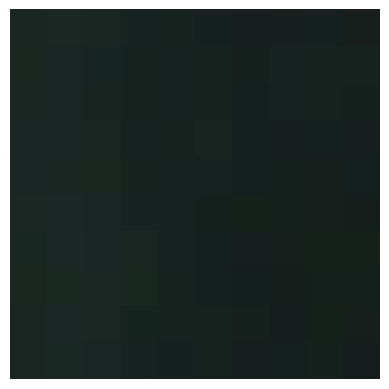

Image Dimensions: torch.Size([3, 10, 10])


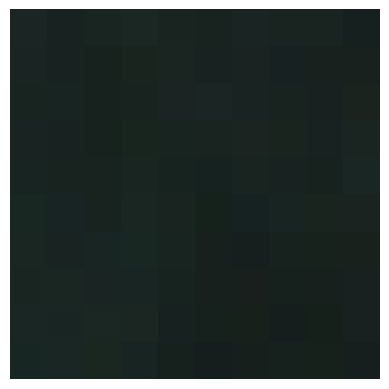

Image Dimensions: torch.Size([3, 10, 10])


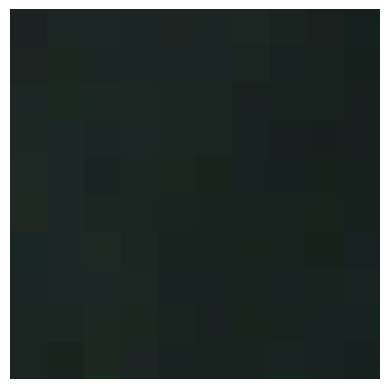

Image Dimensions: torch.Size([3, 10, 10])


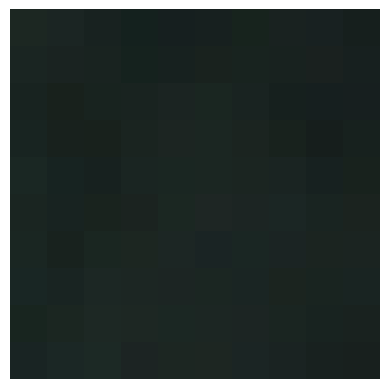

Image Dimensions: torch.Size([3, 10, 10])


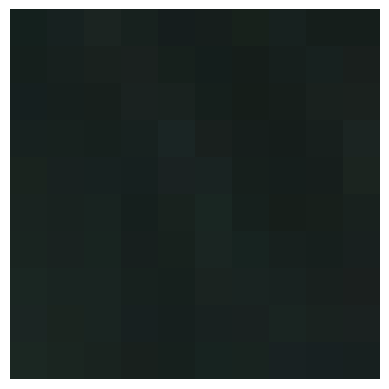

Image Dimensions: torch.Size([3, 10, 10])


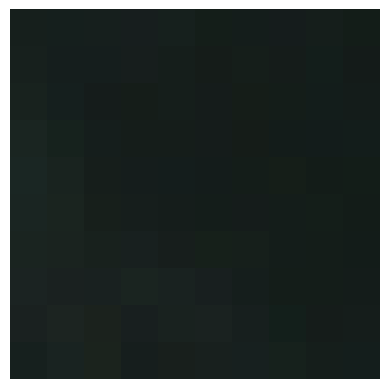

Image Dimensions: torch.Size([3, 10, 10])


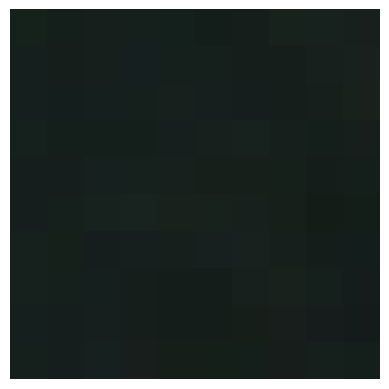

Image Dimensions: torch.Size([3, 10, 10])


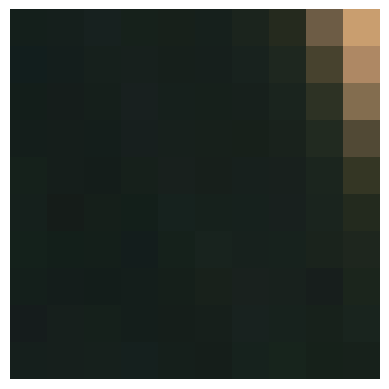

In [42]:
for i in range(len(images)):
  if images[i] is not None and images[i].shape[1] >= 0 and images[i].shape[2] >= 0:
      # Print the dimensions of the image
      print("Image Dimensions:", images[i].shape)
      # Visualize the image
      plt.imshow(images[i].permute(1, 2, 0))  # Assuming image is (C, H, W) and you want to convert to (H, W, C)
      plt.axis('off')
      plt.show()

### Run the model(skip RCF2 if you need this)

In [43]:
class RCF(nn.Module): #RCF inherit nn.module
    """A model for extracting Random Convolution Features (RCF) from input imagery."""

    def __init__(self, num_features=16, kernel_size=3, num_input_channels=3):
        super(RCF, self).__init__() #The function call function of the parent class

        # We create `num_features / 2` filters so require `num_features` to be divisible by 2
        assert num_features % 2 == 0

        self.num_features = num_features  # Store num_features as an instance variable

        self.conv1 = nn.Conv2d(
            num_input_channels,
            num_features // 2,
            kernel_size=kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            bias=True,
        )

        nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
        nn.init.constant_(self.conv1.bias, -1.0)

    def forward(self, x):
        x1a = F.relu(self.conv1(x), inplace=True)
        x1b = F.relu(-self.conv1(x), inplace=True)

        x1a = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()
        x1b = F.adaptive_avg_pool2d(x1b, (1, 1)).squeeze()

        if len(x1a.shape) == 1:  # case where we passed a single input
            return torch.cat((x1a, x1b), dim=0)
        elif len(x1a.shape) == 2:  # case where we passed a batch of > 1 inputs
            return torch.cat((x1a, x1b), dim=1)


In [44]:
# Define the numbers of features for each model
feature_numbers = [100]

# Create a list to store models
models = []

# Create models with different numbers of features
for num_features in feature_numbers:
#    device = torch.device("cuda")
    model = RCF(num_features=num_features).eval().to()
    models.append(model)


### Run the model2(skip RCF if you need this)

In [55]:
class RCF2(nn.Module):
    """A model for extracting Random Convolution Features (RCF2) from input imagery."""

    def __init__(self, num_features=16, kernel_size=3, num_input_channels=3, dropout_prob=0.5):
        super(RCF2, self).__init__()

        # Ensure num_features is divisible by 2
        assert num_features % 2 == 0

        self.num_features = num_features

        self.conv1 = nn.Conv2d(
            num_input_channels,
            num_features // 2,
            kernel_size=kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            bias=True,
        )

        nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
        nn.init.constant_(self.conv1.bias, -1.0)

        # Adding a second convolutional layer
        self.conv2 = nn.Conv2d(
            num_features // 2,
            num_features,
            kernel_size=kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            bias=True,
        )

        nn.init.normal_(self.conv2.weight, mean=0.0, std=1.0)
        nn.init.constant_(self.conv2.bias, -1.0)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x1a = F.relu(self.conv1(x), inplace=True)
        x1b = F.relu(-self.conv1(x), inplace=True)

        # Apply dropout after the first set of convolutions
        x1a = self.dropout(x1a)
        x1b = self.dropout(x1b)

        x2a = F.relu(self.conv2(x1a), inplace=True)
        x2b = F.relu(self.conv2(x1b), inplace=True)

        # Apply dropout after the second set of convolutions
        x2a = self.dropout(x2a)
        x2b = self.dropout(x2b)

        x2a = F.adaptive_avg_pool2d(x2a, (1, 1)).squeeze()
        x2b = F.adaptive_avg_pool2d(x2b, (1, 1)).squeeze()

        if len(x2a.shape) == 1:  # case where we passed a single input
            return torch.cat((x2a, x2b), dim=0)
        elif len(x2a.shape) == 2:  # case where we passed a batch of > 1 inputs
            return torch.cat((x2a, x2b), dim=1)

In [56]:
# Define the numbers of features for each model
expected_feature_numbers = [100]
feature_numbers = [num // 2 for num in expected_feature_numbers]

# Create a list to store models
models = []

# Create models with different numbers of features
for num_features in feature_numbers:
    # Specify the device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model with required parameters
    model = RCF2(num_features=num_features, kernel_size=3, num_input_channels=3, dropout_prob=0.5).eval().to(device)

    # Append the model to the list
    models.append(model)


# store centroid of patch co-ordinates

In [45]:
#store centroid of patch co-ordinates
processed_grid_list = []
processed_grid_list.append([])

for gdf_grid in grid_list:
    # Change to m crs if needed
    gdf_grid = gdf_grid.to_crs(32618)

    # Calculate the centroid of each polygon
    centroids = gdf_grid.geometry.centroid

    # Create a DataFrame with centroid coordinates
    centroids_df = gpd.GeoDataFrame(geometry=centroids, crs=gdf_grid.crs)
    centroids_df['west'] = centroids_df.geometry.x
    centroids_df['east'] = centroids_df.geometry.y

    # Extract necessary columns to form numpy array
    centroids_array = centroids_df[["west", "east"]].to_numpy()

    # Append only the array to the processed_grid_list
    processed_grid_list.append(centroids_array)



In [46]:
for i in range(5):
  print(len(processed_grid_list[i]))

0
218554
54522
24180
13572


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
dataloaders[4]

### Models

We now run the model for different scales, we do this separately to not overload the memory. We start with the widest scale and work down to the smallest.

In [49]:
from sklearn.cluster import DBSCAN, KMeans


In [50]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from itertools import product
import pickle

In [51]:


# Create a dictionary to store results for each model
output_dict4 = {}

# Load existing intermediate results if available
if os.path.exists('finer/intermediate_results/output_dict4.pkl'):
    try:  # Handle potential errors during loading
        with open('finer/intermediate_results/output_dict4.pkl', 'rb') as f:
            output_dict4 = pickle.load(f)
    except EOFError:
        print("Warning: 'finer/intermediate_results/output_dict4.pkl' is empty or corrupted. Starting fresh.")
        output_dict4 = {}  # Initialize as an empty dictionary if loading fails

# Loop over each model
for model in models:
    num_features = model.num_features
    if num_features in output_dict4:
        continue  # Skip already processed models

    x_all = np.zeros((processed_grid_list[4].shape[0], model.num_features), dtype=float)

    # Move model to the same device as the input tensor
    model = model.to(device)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[4]:
        for image in images:
            if image is not None and image.shape[1] >= 0 and image.shape[2] > 0:
                image = image.to(device)
                print(f"Original shape: {image.shape}")
                image = image.unsqueeze(0)
                print(f"Shape after unsqueeze: {image.shape}")
                with torch.no_grad():
                    feats = model(image).cpu().numpy()  # Move result back to CPU and convert to NumPy

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[4].shape[0]} -- {i / processed_grid_list[4].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[4].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[4].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict4[num_features] = x_all

    # Save intermediate results
    with open('finer/intermediate_results/output_dict4.pkl', 'wb') as f:
        pickle.dump(output_dict4, f)

# Access the results for each model
for num_features, x_all in output_dict4.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)


Results for model with 100 features:
[[0.00000000e+00 6.54279860e-03 0.00000000e+00 ... 1.11017931e+00
  1.63142443e+00 6.37118101e-01]
 [0.00000000e+00 2.71569584e-02 0.00000000e+00 ... 1.19323385e+00
  1.77430475e+00 8.04650605e-01]
 [3.79276244e-05 6.10480569e-02 0.00000000e+00 ... 1.19589138e+00
  2.09893036e+00 8.13509822e-01]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.07934177e+00
  1.33763516e+00 7.31068492e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.08215165e+00
  1.35732663e+00 7.11980999e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.07846212e+00
  1.33088779e+00 7.50455022e-01]]


In [52]:


# Create a dictionary to store results for each model
output_dict3 = {}

# Load existing intermediate results if available
if os.path.exists('finer/intermediate_results/output_dict3.pkl'):
    try:  # Handle potential errors during loading
        with open('finer/intermediate_results/output_dict3.pkl', 'rb') as f:
            output_dict3 = pickle.load(f)
    except EOFError:
        print("Warning: 'finer/intermediate_results/output_dict3.pkl' is empty or corrupted. Starting fresh.")
        output_dict3 = {}  # Initialize as an empty dictionary if loading fails

# Loop over each model
for model in models:
    num_features = model.num_features
    if num_features in output_dict3:
        continue  # Skip already processed models

    x_all = np.zeros((processed_grid_list[3].shape[0], model.num_features), dtype=float)

    # Move model to the same device as the input tensor
    model = model.to(device)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[3]:
        for image in images:
            if image is not None and image.shape[1] >= 0 and image.shape[2] > 0:
                image = image.to(device)
                print(f"Original shape: {image.shape}")
                image = image.unsqueeze(0)
                print(f"Shape after unsqueeze: {image.shape}")
                with torch.no_grad():
                    feats = model(image).cpu().numpy()  # Move result back to CPU and convert to NumPy

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[3].shape[0]} -- {i / processed_grid_list[3].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[3].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[3].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict3[num_features] = x_all

    # Save intermediate results
    with open('finer/intermediate_results/output_dict3.pkl', 'wb') as f:
        pickle.dump(output_dict3, f)

# Access the results for each model
for num_features, x_all in output_dict3.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)


Results for model with 100 features:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.65026522e+00
  1.54622781e+00 1.33300793e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.04519868e+00
  1.75901043e+00 1.47165215e+00]
 [3.56814533e-04 0.00000000e+00 0.00000000e+00 ... 2.13785505e+00
  1.78592575e+00 1.64693427e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.43558574e+00
  1.39893913e+00 1.30056155e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.44042659e+00
  1.39787722e+00 1.30610573e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.43832648e+00
  1.38480425e+00 1.31627917e+00]]


In [53]:


# Create a dictionary to store results for each model
output_dict2 = {}

# Load existing intermediate results if available
if os.path.exists('finer/intermediate_results/output_dict2.pkl'):
    try:  # Handle potential errors during loading
        with open('finer/intermediate_results/output_dict2.pkl', 'rb') as f:
            output_dict2 = pickle.load(f)
    except EOFError:
        print("Warning: 'finer/intermediate_results/output_dict2.pkl' is empty or corrupted. Starting fresh.")
        output_dict2 = {}  # Initialize as an empty dictionary if loading fails

# Loop over each model
for model in models:
    num_features = model.num_features
    if num_features in output_dict2:
        continue  # Skip already processed models

    x_all = np.zeros((processed_grid_list[2].shape[0], model.num_features), dtype=float)

    # Move model to the same device as the input tensor
    model = model.to(device)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[2]:
        for image in images:
            if image is not None and image.shape[1] >= 0 and image.shape[2] > 0:
                image = image.to(device)
                print(f"Original shape: {image.shape}")
                image = image.unsqueeze(0)
                print(f"Shape after unsqueeze: {image.shape}")
                with torch.no_grad():
                    feats = model(image).cpu().numpy()  # Move result back to CPU and convert to NumPy

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[2].shape[0]} -- {i / processed_grid_list[2].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[2].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[2].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict2[num_features] = x_all

    # Save intermediate results
    with open('finer/intermediate_results/output_dict2.pkl', 'wb') as f:
        pickle.dump(output_dict2, f)

# Access the results for each model
for num_features, x_all in output_dict2.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

Results for model with 100 features:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.68228948e-01 8.99802208e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.58700073e-01 8.98266196e-01]
 [0.00000000e+00 9.39683407e-04 8.53838772e-03 ... 0.00000000e+00
  7.66272545e-01 9.18964982e-01]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.81907856e-01 9.64408994e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.73205221e-01 9.74753857e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.57316947e-01 9.93940413e-01]]


In [54]:


# Create a dictionary to store results for each model
output_dict1 = {}

# Load existing intermediate results if available
if os.path.exists('finer/intermediate_results/output_dict1.pkl'):
    try:  # Handle potential errors during loading
        with open('finer/intermediate_results/output_dict1.pkl', 'rb') as f:
            output_dict1 = pickle.load(f)
    except EOFError:
        print("Warning: 'finer/intermediate_results/output_dict1.pkl' is empty or corrupted. Starting fresh.")
        output_dict1 = {}  # Initialize as an empty dictionary if loading fails

# Loop over each model
for model in models:
    num_features = model.num_features
    if num_features in output_dict1:
        continue  # Skip already processed models

    x_all = np.zeros((processed_grid_list[1].shape[0], model.num_features), dtype=float)

    # Move model to the same device as the input tensor
    model = model.to(device)

    tic = time.time()
    i = 0

    # Iterate over each image in the dataloader
    for images in dataloaders[1]:
        for image in images:
            if image is not None and image.shape[1] >= 0 and image.shape[2] > 0:
                image = image.to(device)
                print(f"Original shape: {image.shape}")
                image = image.unsqueeze(0)
                print(f"Shape after unsqueeze: {image.shape}")
                with torch.no_grad():
                    feats = model(image).cpu().numpy()  # Move result back to CPU and convert to NumPy

                x_all[i] = feats

                if i % 1000 == 0:
                    print(
                        f"{i}/{processed_grid_list[1].shape[0]} -- {i / processed_grid_list[1].shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                    # Save intermediate results more frequently
                    output_dict1[num_features] = x_all
                    with open('finer1/intermediate_results/output_dict1.pkl', 'wb') as f:
                        pickle.dump(output_dict1, f)

                i += 1

                # Check if i exceeds the number of points, break the loop
                if i >= processed_grid_list[1].shape[0]:
                    break

        # Check if i exceeds the number of points, break the loop
        if i >= processed_grid_list[1].shape[0]:
            break

    # Store x_all in the dictionary for the current model
    output_dict1[num_features] = x_all

    # Save final results for the current model
    with open('finer/intermediate_results/output_dict1.pkl', 'wb') as f:
        pickle.dump(output_dict1, f)

# Access the results for each model
for num_features, x_all in output_dict1.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)


Results for model with 100 features:
[[0.         0.         0.         ... 0.74180949 0.18966204 0.05975226]
 [0.         0.         0.         ... 0.72930139 0.17490876 0.03364896]
 [0.         0.         0.         ... 0.73171914 0.14645246 0.02731307]
 ...
 [0.         0.         0.         ... 0.69072777 0.35902041 0.44425577]
 [0.         0.         0.         ... 0.68456835 0.35677016 0.46433657]
 [0.         0.         0.         ... 0.68009114 0.32647192 0.43304649]]


Run all RCF2 for all dataloaders

In [57]:
# Initialize variables

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
# Set the index `i` for the dataloader to use
i = 4  # Changed this value to 4

output_dict4_RCF2 = {}

# Load existing intermediate results if available
if os.path.exists(f'finer/intermediate_results/output_dict{i}_RCF2.pkl'):
    try:  # Handle potential errors during loading
        with open(f'finer/intermediate_results/output_dict{i}_RCF2.pkl', 'rb') as f:
            output_dict4_RCF2 = pickle.load(f)
    except EOFError:
        print(f"Warning: 'finer/intermediate_results/output_dict{i}_RCF2.pkl' is empty or corrupted. Starting fresh.")
        output_dict4_RCF2 = {}  # Initialize as an empty dictionary if loading fails

# Ensure `i` is within the valid range
if i < 1 or i > 9:
    raise ValueError("Index `i` should be between 1 and 9")

# Get the dataloader for the specified index (adjust for zero-based indexing if necessary)
# Assuming `dataloaders` is a predefined list of dataloaders
dataloader = dataloaders[i]  # Adjust this line based on your dataloader implementation

# Loop over each model
for model in models:
    num_features = model.num_features * 2  # Adjust num_features for the concatenated output
    if num_features in output_dict4_RCF2:
        continue  # Skip already processed models

    x_all = np.zeros((len(dataloader.dataset), num_features), dtype=float)
    model = model.to(device)
    tic = time.time()
    idx = 0

    # Iterate over each image in the dataloader
    for batch_idx, images in enumerate(dataloader):
        for img_idx, image in enumerate(images):
            if image is not None and image.shape[1] >= 0 and image.shape[2] > 0:
                image = image.to(device)
                print(f"Batch {batch_idx}, Image {img_idx} - Original shape: {image.shape}")
                image = image.unsqueeze(0)
                print(f"Batch {batch_idx}, Image {img_idx} - Shape after unsqueeze: {image.shape}")
                with torch.no_grad():
                    feats = model(image).cpu().numpy()  # Move result back to CPU and convert to NumPy

                # Ensure the extracted features match the expected number of features
                if feats.shape[0] != num_features:
                    raise ValueError(f"Extracted features shape {feats.shape[0]} does not match expected {num_features}")

                x_all[idx] = feats

                if idx % 1000 == 0:
                    print(
                        f"{idx}/{len(dataloader.dataset)} -- {idx / len(dataloader.dataset) * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                idx += 1

                # Check if idx exceeds the number of points, break the loop
                if idx >= len(dataloader.dataset):
                    break

        # Check if idx exceeds the number of points, break the loop
        if idx >= len(dataloader.dataset):
            break

    # Store x_all in the dictionary for the current model
    output_dict4_RCF2[num_features] = x_all

    # Save intermediate results
    with open(f'finer/intermediate_results/output_dict{i}_RCF2.pkl', 'wb') as f:
        pickle.dump(output_dict4_RCF2, f)

# Access the results for each model
for num_features, x_all in output_dict4_RCF2.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

Results for model with 100 features:
[[8.35238770e-03 2.32795998e-01 2.08896678e-02 ... 2.91941338e+01
  7.19063837e-06 2.62813549e+01]
 [3.53868335e-01 1.31377733e+00 1.53999496e-02 ... 3.51898727e+01
  1.02089874e-01 2.76619225e+01]
 [2.51667887e-01 2.18963432e+00 1.18080772e-01 ... 4.11523552e+01
  1.47919402e-01 2.70368748e+01]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.57347603e+01
  0.00000000e+00 3.00081024e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.58175182e+01
  0.00000000e+00 2.97446232e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.58231468e+01
  0.00000000e+00 3.00663166e+01]]


In [59]:
# Set the index `i` for the dataloader to use
i = 3  # Changed this value to 3

output_dict3_RCF2 = {}

# Load existing intermediate results if available
if os.path.exists(f'finer/intermediate_results/output_dict{i}_RCF2.pkl'):
    try:  # Handle potential errors during loading
        with open(f'finer/intermediate_results/output_dict{i}_RCF2.pkl', 'rb') as f:
            output_dict3_RCF2 = pickle.load(f)
    except EOFError:
        print(f"Warning: 'finer/intermediate_results/output_dict{i}_RCF2.pkl' is empty or corrupted. Starting fresh.")
        output_dict3_RCF2 = {}  # Initialize as an empty dictionary if loading fails

# Ensure `i` is within the valid range
if i < 1 or i > 9:
    raise ValueError("Index `i` should be between 1 and 9")

# Get the dataloader for the specified index (adjust for zero-based indexing if necessary)
# Assuming `dataloaders` is a predefined list of dataloaders
dataloader = dataloaders[i]  # Adjust this line based on your dataloader implementation

# Loop over each model
for model in models:
    num_features = model.num_features * 2  # Adjust num_features for the concatenated output
    if num_features in output_dict3_RCF2:
        continue  # Skip already processed models

    x_all = np.zeros((len(dataloader.dataset), num_features), dtype=float)
    model = model.to(device)
    tic = time.time()
    idx = 0

    # Iterate over each image in the dataloader
    for batch_idx, images in enumerate(dataloader):
        for img_idx, image in enumerate(images):
            if image is not None and image.shape[1] >= 0 and image.shape[2] > 0:
                image = image.to(device)
                print(f"Batch {batch_idx}, Image {img_idx} - Original shape: {image.shape}")
                image = image.unsqueeze(0)
                print(f"Batch {batch_idx}, Image {img_idx} - Shape after unsqueeze: {image.shape}")
                with torch.no_grad():
                    feats = model(image).cpu().numpy()  # Move result back to CPU and convert to NumPy

                # Ensure the extracted features match the expected number of features
                if feats.shape[0] != num_features:
                    raise ValueError(f"Extracted features shape {feats.shape[0]} does not match expected {num_features}")

                x_all[idx] = feats

                if idx % 1000 == 0:
                    print(
                        f"{idx}/{len(dataloader.dataset)} -- {idx / len(dataloader.dataset) * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                idx += 1

                # Check if idx exceeds the number of points, break the loop
                if idx >= len(dataloader.dataset):
                    break

        # Check if idx exceeds the number of points, break the loop
        if idx >= len(dataloader.dataset):
            break

    # Store x_all in the dictionary for the current model
    output_dict3_RCF2[num_features] = x_all

    # Save intermediate results
    with open(f'finer/intermediate_results/output_dict{i}_RCF2.pkl', 'wb') as f:
        pickle.dump(output_dict3_RCF2, f)

# Access the results for each model
for num_features, x_all in output_dict3_RCF2.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

Results for model with 100 features:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.79364834e+01
  0.00000000e+00 2.62048798e+01]
 [1.52778000e-01 1.14930558e+00 2.75618546e-02 ... 3.22772789e+01
  3.35601605e-02 2.75389996e+01]
 [3.78896445e-01 1.25821698e+00 1.14083951e-02 ... 3.53473778e+01
  1.52894482e-01 2.74728069e+01]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.57254887e+01
  0.00000000e+00 2.97814331e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.57900734e+01
  0.00000000e+00 2.98126678e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.58052082e+01
  0.00000000e+00 3.00990601e+01]]


In [60]:
# Set the index `i` for the dataloader to use
i = 2  # Changed this value to 2

output_dict2_RCF2 = {}

# Load existing intermediate results if available
if os.path.exists(f'finer/intermediate_results/output_dict{i}_RCF2.pkl'):
    try:  # Handle potential errors during loading
        with open(f'finer/intermediate_results/output_dict{i}_RCF2.pkl', 'rb') as f:
            output_dict2_RCF2 = pickle.load(f)
    except EOFError:
        print(f"Warning: 'finer/intermediate_results/output_dict{i}_RCF2.pkl' is empty or corrupted. Starting fresh.")
        output_dict2_RCF2 = {}  # Initialize as an empty dictionary if loading fails

# Ensure `i` is within the valid range
if i < 1 or i > 9:
    raise ValueError("Index `i` should be between 1 and 9")

# Get the dataloader for the specified index (adjust for zero-based indexing if necessary)
# Assuming `dataloaders` is a predefined list of dataloaders
dataloader = dataloaders[i]  # Adjust this line based on your dataloader implementation

# Loop over each model
for model in models:
    num_features = model.num_features * 2  # Adjust num_features for the concatenated output
    if num_features in output_dict2_RCF2:
        continue  # Skip already processed models

    x_all = np.zeros((len(dataloader.dataset), num_features), dtype=float)
    model = model.to(device)
    tic = time.time()
    idx = 0

    # Iterate over each image in the dataloader
    for batch_idx, images in enumerate(dataloader):
        for img_idx, image in enumerate(images):
            if image is not None and image.shape[1] >= 0 and image.shape[2] > 0:
                image = image.to(device)
                print(f"Batch {batch_idx}, Image {img_idx} - Original shape: {image.shape}")
                image = image.unsqueeze(0)
                print(f"Batch {batch_idx}, Image {img_idx} - Shape after unsqueeze: {image.shape}")
                with torch.no_grad():
                    feats = model(image).cpu().numpy()  # Move result back to CPU and convert to NumPy

                # Ensure the extracted features match the expected number of features
                if feats.shape[0] != num_features:
                    raise ValueError(f"Extracted features shape {feats.shape[0]} does not match expected {num_features}")

                x_all[idx] = feats

                if idx % 1000 == 0:
                    print(
                        f"{idx}/{len(dataloader.dataset)} -- {idx / len(dataloader.dataset) * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                idx += 1

                # Check if idx exceeds the number of points, break the loop
                if idx >= len(dataloader.dataset):
                    break

        # Check if idx exceeds the number of points, break the loop
        if idx >= len(dataloader.dataset):
            break

    # Store x_all in the dictionary for the current model
    output_dict2_RCF2[num_features] = x_all

    # Save intermediate results
    with open(f'finer/intermediate_results/output_dict{i}_RCF2.pkl', 'wb') as f:
        pickle.dump(output_dict2_RCF2, f)

# Access the results for each model
for num_features, x_all in output_dict2_RCF2.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)

Results for model with 100 features:
[[ 0.          0.          0.         ... 23.42881966  9.54282951
   0.        ]
 [ 0.          0.          0.         ... 23.57800293  9.83527184
   0.        ]
 [ 0.06735341  0.14785506  0.         ... 23.59683609  9.67289352
   0.        ]
 ...
 [ 0.          0.          0.         ... 23.64766312  7.84067249
   0.        ]
 [ 0.          0.          0.         ... 23.76667404  7.79792786
   0.        ]
 [ 0.          0.          0.         ... 23.9553299   7.76326513
   0.        ]]


In [61]:

# Set the index `i` for the dataloader to use (can be changed for testing)
i = 1  # Change this value to test different dataloaders

output_dict1_RCF2 = {}

# Load existing intermediate results if available
if os.path.exists(f'finer/intermediate_results/output_dict{i}_RCF2.pkl'):
    try:  # Handle potential errors during loading
        with open(f'finer/intermediate_results/output_dict{i}_RCF2.pkl', 'rb') as f:
            output_dict1_RCF2 = pickle.load(f)
    except EOFError:
        print(f"Warning: 'finer/intermediate_results/output_dict{i}_RCF2.pkl' is empty or corrupted. Starting fresh.")
        output_dict1_RCF2 = {}  # Initialize as an empty dictionary if loading fails

# Ensure `i` is within the valid range
if i < 1 or i > 9:
    raise ValueError("Index `i` should be between 1 and 9")

# Get the dataloader for the specified index
dataloader = dataloaders[i]  # Adjust for zero-based indexing

# Loop over each model
for model in models:
    num_features = model.num_features * 2  # Adjust num_features for the concatenated output
    if num_features in output_dict1_RCF2:
        continue  # Skip already processed models

    x_all = np.zeros((len(dataloader.dataset), num_features), dtype=float)
    model = model.to(device)
    tic = time.time()
    idx = 0

    # Iterate over each image in the dataloader
    for batch_idx, images in enumerate(dataloader):
        for img_idx, image in enumerate(images):
            if image is not None and image.shape[1] >= 0 and image.shape[2] > 0:
                image = image.to(device)
                print(f"Batch {batch_idx}, Image {img_idx} - Original shape: {image.shape}")
                image = image.unsqueeze(0)
                print(f"Batch {batch_idx}, Image {img_idx} - Shape after unsqueeze: {image.shape}")
                with torch.no_grad():
                    feats = model(image).cpu().numpy()  # Move result back to CPU and convert to NumPy

                # Ensure the extracted features match the expected number of features
                if feats.shape[0] != num_features:
                    raise ValueError(f"Extracted features shape {feats.shape[0]} does not match expected {num_features}")

                x_all[idx] = feats

                if idx % 1000 == 0:
                    print(
                        f"{idx}/{len(dataloader.dataset)} -- {idx / len(dataloader.dataset) * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()

                idx += 1

                # Check if idx exceeds the number of points, break the loop
                if idx >= len(dataloader.dataset):
                    break

        # Check if idx exceeds the number of points, break the loop
        if idx >= len(dataloader.dataset):
            break

    # Store x_all in the dictionary for the current model
    output_dict1_RCF2[num_features] = x_all

    # Save intermediate results
    with open(f'finer/intermediate_results/output_dict{i}_RCF2.pkl', 'wb') as f:
        pickle.dump(output_dict1_RCF2, f)

# Access the results for each model
for num_features, x_all in output_dict1_RCF2.items():
    print(f"Results for model with {num_features} features:")
    print(x_all)


Results for model with 100 features:
[[0.         0.         0.         ... 0.         0.         4.39097786]
 [0.         0.         0.         ... 0.         0.         3.77080274]
 [0.         0.         0.         ... 0.         0.         3.55544209]
 ...
 [0.         0.         0.         ... 0.         0.         7.01680326]
 [0.         0.         0.         ... 0.         0.         6.9672904 ]
 [0.         0.         0.         ... 0.         0.         6.70854187]]


Random Forest and XGBoost prediction with scale comparison(do this after 2nd spatial join notebook)

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import time
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb




# Function to evaluate the model
def evaluate_model(model, X, y_true, label):
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} - MSE: {mse}, R2: {r2}")
    return y_pred, mse, r2

# Function to plot the results and save to file
def plot_results_grid(
      y_green, y_green_pred, mse_green, r2_green,
      y_blue, y_blue_pred, mse_blue, r2_blue,
      y_building, y_building_pred, mse_building, r2_building,
      y_temp, y_temp_pred, mse_temp, r2_temp,
      y_temp_pred_xgb, mse_temp_xgb, r2_temp_xgb,
      y_green_pred_RCF2, mse_green_RCF2, r2_green_RCF2,
      y_blue_pred_RCF2, mse_blue_RCF2, r2_blue_RCF2,
      y_building_pred_RCF2, mse_building_RCF2, r2_building_RCF2,
      y_temp_pred_RCF2, mse_temp_RCF2, r2_temp_RCF2,
      y_temp_pred_xgb_RCF2, mse_temp_xgb_RCF2, r2_temp_xgb_RCF2,
      title_prefix, save_path
  ):
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    # Green space ratio (RF)
    axes[0, 0].scatter(y_green, y_green_pred, c='green', marker='o', edgecolor='white', label='Predicted vs Actual')
    axes[0, 0].plot([min(y_green), max(y_green)], [min(y_green), max(y_green)], color='red', linewidth=2, linestyle='--')
    axes[0, 0].set_xlabel('Actual Green Space Ratio')
    axes[0, 0].set_ylabel('Predicted Green Space Ratio')
    axes[0, 0].set_title(f'{title_prefix} Green Space Ratio (RCF RF)\nMSE: {mse_green:.4f}, R2: {r2_green:.4f}')

    # Blue space ratio (RF)
    axes[0, 1].scatter(y_blue, y_blue_pred, c='blue', marker='o', edgecolor='white', label='Predicted vs Actual')
    axes[0, 1].plot([min(y_blue_pred), max(y_blue_pred)], [min(y_blue_pred), max(y_blue_pred)], color='red', linewidth=2, linestyle='--')
    axes[0, 1].set_xlabel('Actual Blue Space Ratio')
    axes[0, 1].set_ylabel('Predicted Blue Space Ratio')
    axes[0, 1].set_title(f'{title_prefix} Blue Space Ratio (RCF RF)\nMSE: {mse_blue:.4f}, R2: {r2_blue:.4f}')

    # Building area ratio (RF)
    axes[0, 2].scatter(y_building, y_building_pred, c='brown', marker='o', edgecolor='white', label='Predicted vs Actual')
    axes[0, 2].plot([min(y_building), max(y_building)], [min(y_building), max(y_building)], color='red', linewidth=2, linestyle='--')
    axes[0, 2].set_xlabel('Actual Building Area Ratio')
    axes[0, 2].set_ylabel('Predicted Building Area Ratio')
    axes[0, 2].set_title(f'{title_prefix} Building Area Ratio (RCF RF)\nMSE: {mse_building:.4f}, R2: {r2_building:.4f}')

    # Average temperature (RF)
    axes[0, 3].scatter(y_temp, y_temp_pred, c='orange', marker='o', edgecolor='white', label='Predicted vs Actual')
    axes[0, 3].plot([min(y_temp), max(y_temp)], [min(y_temp), max(y_temp)], color='red', linewidth=2, linestyle='--')
    axes[0, 3].set_xlabel('Actual Average Temperature')
    axes[0, 3].set_ylabel('Predicted Average Temperature')
    axes[0, 3].set_title(f'{title_prefix} Average Temperature (RCF RF)\nMSE: {mse_temp:.4f}, R2: {r2_temp:.4f}')

    # Average temperature (XGBoost)
    axes[0, 4].scatter(y_temp, y_temp_pred_xgb, c='orange', marker='o', edgecolor='white', label='Predicted vs Actual')
    axes[0, 4].plot([min(y_temp), max(y_temp)], [min(y_temp), max(y_temp)], color='red', linewidth=2, linestyle='--')
    axes[0, 4].set_xlabel('Actual Average Temperature')
    axes[0, 4].set_ylabel('Predicted Average Temperature')
    axes[0, 4].set_title(f'{title_prefix} Average Temperature (RCF XGBoost)\nMSE: {mse_temp_xgb:.4f}, R2: {r2_temp_xgb:.4f}')

    # Green space ratio (RCF2)
    axes[1, 0].scatter(y_green, y_green_pred_RCF2, c='green', marker='o', edgecolor='white', label='Predicted vs Actual')
    axes[1, 0].plot([min(y_green), max(y_green)], [min(y_green), max(y_green)], color='red', linewidth=2, linestyle='--')
    axes[1, 0].set_xlabel('Actual Green Space Ratio')
    axes[1, 0].set_ylabel('Predicted Green Space Ratio')
    axes[1, 0].set_title(f'{title_prefix} Green Space Ratio (RCF2)\nMSE: {mse_green_RCF2:.4f}, R2: {r2_green_RCF2:.4f}')

    # Blue space ratio (RCF2)
    axes[1, 1].scatter(y_blue, y_blue_pred_RCF2, c='blue', marker='o', edgecolor='white', label='Predicted vs Actual')
    axes[1, 1].plot([min(y_blue), max(y_blue)], [min(y_blue), max(y_blue)], color='red', linewidth=2, linestyle='--')
    axes[1, 1].set_xlabel('Actual Blue Space Ratio')
    axes[1, 1].set_ylabel('Predicted Blue Space Ratio')
    axes[1, 1].set_title(f'{title_prefix} Blue Space Ratio (RCF2)\nMSE: {mse_blue_RCF2:.4f}, R2: {r2_blue_RCF2:.4f}')

    # Building area ratio (RCF2)
    axes[1, 2].scatter(y_building, y_building_pred_RCF2, c='brown', marker='o', edgecolor='white', label='Predicted vs Actual')
    axes[1, 2].plot([min(y_building), max(y_building)], [min(y_building), max(y_building)], color='red', linewidth=2, linestyle='--')
    axes[1, 2].set_xlabel('Actual Building Area Ratio')
    axes[1, 2].set_ylabel('Predicted Building Area Ratio')
    axes[1, 2].set_title(f'{title_prefix} Building Area Ratio (RCF2)\nMSE: {mse_building_RCF2:.4f}, R2: {r2_building_RCF2:.4f}')

    # Average temperature (RCF2RF)
    axes[1, 3].scatter(y_temp, y_temp_pred_RCF2, c='purple', marker='o', edgecolor='white', label='Predicted vs Actual')
    axes[1, 3].plot([min(y_temp), max(y_temp)], [min(y_temp), max(y_temp)], color='red', linewidth=2, linestyle='--')
    axes[1, 3].set_xlabel('Actual Average Temperature')
    axes[1, 3].set_ylabel('Predicted Average Temperature')
    axes[1, 3].set_title(f'{title_prefix} Average Temperature ((RCF2 RF)\nMSE: {mse_temp_RCF2:.4f}, R2: {r2_temp_RCF2:.4f}')

    # Average temperature (RCF2XGBoost)
    axes[1, 4].scatter(y_temp, y_temp_pred_xgb_RCF2, c='purple', marker='o', edgecolor='white', label='Predicted vs Actual')
    axes[1, 4].plot([min(y_temp), max(y_temp)], [min(y_temp), max(y_temp)], color='red', linewidth=2, linestyle='--')
    axes[1, 4].set_xlabel('Actual Average Temperature')
    axes[1, 4].set_ylabel('Predicted Average Temperature')
    axes[1, 4].set_title(f'{title_prefix} Average Temperature (RCF2 XGBoost)\nMSE: {mse_temp_xgb_RCF2:.4f}, R2: {r2_temp_xgb_RCF2:.4f}')


    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()


# Ensure the main folder exists
main_folder = "finer/XGBoostRandomForest"
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

# Assume the dictionaries output_dict1 to output_dict9 and output_dict1_RCF2 to output_dict9_RCF2 are already loaded in the environment
output_dicts_RCF = [output_dict1, output_dict2, output_dict3, output_dict4]
output_dicts_RCF2 = [output_dict1_RCF2, output_dict2_RCF2, output_dict3_RCF2, output_dict4_RCF2]

# Iterate over the different feature sets
for i in range(1, 5):

    # Create subfolder for current iteration
    iteration_folder = os.path.join(main_folder, f"df{i}")
    if not os.path.exists(iteration_folder):
        os.makedirs(iteration_folder)

    # Load the green, blue, and building space ratios
    ratios_df = pd.read_csv(f'finer/green_blue_building_ratios_grid_{i}_new.csv')  # Updated filename to include building ratio
    print(ratios_df)

    # Load the data for average temperature
    spatial_joined_file = f'finer/spatial_joined_data_temperature/gridlist_{i-1}_with_temperature.csv'
    temperature_df = pd.read_csv(spatial_joined_file)

    # Print this iteration
    print(f"Iteration {i}")

    # Load RCF and RCF2 features
    output_dict_RCF = output_dicts_RCF[i-1]
    output_dict_RCF2 = output_dicts_RCF2[i-1]

    num_features = 100
    image_features_RCF = output_dict_RCF[num_features]
    print('len(image_features_RCF)', len(image_features_RCF))
    image_features_RCF2 = output_dict_RCF2[num_features]
    print('len(image_features_RCF2)', len(image_features_RCF2))

    # Print the lengths of each DataFrame
    print(f"Iteration {i}")
    print(f"Length of image_features_RCF: {len(image_features_RCF)}")
    print(f"Length of ratios_df: {len(ratios_df)}")
    print(f"Length of temperature_df: {len(temperature_df)}")

    print(f"Length of image_features_RCF2: {len(image_features_RCF2)}")


    # Ensure the number of samples matches between image features, ratios, and temperature data
    assert len(image_features_RCF) == len(ratios_df) == len(temperature_df), "Number of samples mismatch after aligning datasets"
    assert len(image_features_RCF2) == len(ratios_df) == len(temperature_df), "Number of samples mismatch after aligning datasets"

    # Combine the data into a single DataFrame
    print(image_features_RCF.shape)
    combined_df_RCF = pd.DataFrame(image_features_RCF, columns=[f'feature_{j+1}' for j in range(image_features_RCF.shape[1])])
    combined_df_RCF['green_ratio'] = ratios_df['green_ratio'].values
    combined_df_RCF['blue_ratio'] = ratios_df['blue_ratio'].values
    combined_df_RCF['building_ratio'] = ratios_df['building_ratio'].values
    combined_df_RCF['average_temperature'] = temperature_df['average_temperature'].values

    combined_df_RCF2 = pd.DataFrame(image_features_RCF2, columns=[f'feature_{j+1}' for j in range(image_features_RCF2.shape[1])])
    combined_df_RCF2['green_ratio'] = ratios_df['green_ratio'].values
    combined_df_RCF2['blue_ratio'] = ratios_df['blue_ratio'].values
    combined_df_RCF2['building_ratio'] = ratios_df['building_ratio'].values
    combined_df_RCF2['average_temperature'] = temperature_df['average_temperature'].values

    # Drop rows with NaN values in the average_temperature column and their corresponding image features
    combined_df_RCF.dropna(subset=['average_temperature'], inplace=True)
    combined_df_RCF2.dropna(subset=['average_temperature'], inplace=True)

    # Check if there are enough data points after dropping NaNs
    if len(combined_df_RCF) < 2 or len(combined_df_RCF2) < 2:
        print(f"Not enough valid data for iteration {i} after dropping NaNs.")
        continue

    # Separate features and target variables
    X_RCF = combined_df_RCF.iloc[:, :-4]  # Image features; a pandas method used for selecting rows and columns by their integer positions (index-based selection).
    #The colon : indicates that all rows in the DataFrame are being selected.
    #:-4 means all columns except the last four are selected. In other words, this slice starts from the first column and goes up to, but does not include, the last four columns.
    y_green = combined_df_RCF['green_ratio']  # Green space ratio
    y_blue = combined_df_RCF['blue_ratio']  # Blue space ratio
    y_building = combined_df_RCF['building_ratio']  # Building area ratio
    y_temperature = combined_df_RCF['average_temperature']  # Average temperature

    X_RCF2 = combined_df_RCF2.iloc[:, :-4]  # Image features

    # Perform regression for green space ratio using Random Forest
    print(f"Random Forest Regression for Green Space Ratio with RCF {i}")
    regressor_green = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor_green.fit(X_RCF, y_green)
    y_green_pred, mse_green, r2_green = evaluate_model(regressor_green, X_RCF, y_green, f"Green Space Ratio Random Forest Regression with RCF {i}")

    print(f"Random Forest Regression for Green Space Ratio with RCF2 {i}")
    regressor_green_RCF2 = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor_green_RCF2.fit(X_RCF2, y_green)
    y_green_pred_RCF2, mse_green_RCF2, r2_green_RCF2 = evaluate_model(regressor_green_RCF2, X_RCF2, y_green, f"Green Space Ratio Random Forest Regression with RCF2 {i}")

    # Perform regression for blue space ratio using Random Forest
    print(f"Random Forest Regression for Blue Space Ratio with RCF {i}")
    regressor_blue = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor_blue.fit(X_RCF, y_blue)
    y_blue_pred, mse_blue, r2_blue = evaluate_model(regressor_blue, X_RCF, y_blue, f"Blue Space Ratio Random Forest Regression with RCF {i}")

    print(f"Random Forest Regression for Blue Space Ratio with RCF2 {i}")
    regressor_blue_RCF2 = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor_blue_RCF2.fit(X_RCF2, y_blue)
    y_blue_pred_RCF2, mse_blue_RCF2, r2_blue_RCF2 = evaluate_model(regressor_blue_RCF2, X_RCF2, y_blue, f"Blue Space Ratio Random Forest Regression with RCF2 {i}")

    # Perform regression for building area ratio using Random Forest
    print(f"Random Forest Regression for Building Area Ratio with RCF {i}")
    regressor_building = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor_building.fit(X_RCF, y_building)
    y_building_pred, mse_building, r2_building = evaluate_model(regressor_building, X_RCF, y_building, f"Building Area Ratio Random Forest Regression with RCF {i}")

    print(f"Random Forest Regression for Building Area Ratio with RCF2 {i}")
    regressor_building_RCF2 = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor_building_RCF2.fit(X_RCF2, y_building)
    y_building_pred_RCF2, mse_building_RCF2, r2_building_RCF2 = evaluate_model(regressor_building_RCF2, X_RCF2, y_building, f"Building Area Ratio Random Forest Regression with RCF2 {i}")

    # Perform regression for average temperature using Random Forest
    print(f"Random Forest Regression for Average Temperature with RCF {i}")
    regressor_temp = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor_temp.fit(X_RCF, y_temperature)
    y_temp_pred, mse_temp, r2_temp = evaluate_model(regressor_temp, X_RCF, y_temperature, f"Average Temperature Random Forest Regression with RCF {i}")

    print(f"Random Forest Regression for Average Temperature with RCF2 {i}")
    regressor_temp_RCF2 = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor_temp_RCF2.fit(X_RCF2, y_temperature)
    y_temp_pred_RCF2, mse_temp_RCF2, r2_temp_RCF2 = evaluate_model(regressor_temp_RCF2, X_RCF2, y_temperature, f"Average Temperature Random Forest Regression with RCF2 {i}")

    # Perform XGBoost regression for average temperature
    print(f"XGBoost Regression for Average Temperature with RCF {i}")
    regressor_temp_xgb = xgb.XGBRegressor(n_estimators=100, random_state=42)
    regressor_temp_xgb.fit(X_RCF, y_temperature)
    y_temp_pred_xgb, mse_temp_xgb, r2_temp_xgb = evaluate_model(regressor_temp_xgb, X_RCF, y_temperature, f"Average Temperature XGBoost Regression with RCF {i}")

    print(f"XGBoost Regression for Average Temperature with RCF2 {i}")
    regressor_temp_xgb_RCF2 = xgb.XGBRegressor(n_estimators=100, random_state=42)
    regressor_temp_xgb_RCF2.fit(X_RCF2, y_temperature)
    y_temp_pred_xgb_RCF2, mse_temp_xgb_RCF2, r2_temp_xgb_RCF2 = evaluate_model(regressor_temp_xgb_RCF2, X_RCF2, y_temperature, f"Average Temperature XGBoost Regression with RCF2 {i}")


    # Perform the evaluation and plotting
    plot_results_grid(
        y_green, y_green_pred, mse_green, r2_green,
        y_blue, y_blue_pred, mse_blue, r2_blue,
        y_building, y_building_pred, mse_building, r2_building,
        y_temperature, y_temp_pred, mse_temp, r2_temp,
        y_temp_pred_xgb, mse_temp_xgb, r2_temp_xgb,
        y_green_pred_RCF2, mse_green_RCF2, r2_green_RCF2,
        y_blue_pred_RCF2, mse_blue_RCF2, r2_blue_RCF2,
        y_building_pred_RCF2, mse_building_RCF2, r2_building_RCF2,
        y_temp_pred_RCF2, mse_temp_RCF2, r2_temp_RCF2,
        y_temp_pred_xgb_RCF2, mse_temp_xgb_RCF2, r2_temp_xgb_RCF2,
        f'Iteration {i}', f'finer1/XGBoostRandomForest/5*2comparison_grid_{i}.png'
    )

    # Save the temporal pickle file after each iteration
    temp_pickle_path = os.path.join(iteration_folder, f'iteration_{i}_results.pkl')
    with open(temp_pickle_path, 'wb') as f:
        pickle.dump({
            'y_green_pred': y_green_pred,
            'y_blue_pred': y_blue_pred,
            'y_building_pred': y_building_pred,
            'y_temp_pred': y_temp_pred,
            'y_temp_pred_xgb': y_temp_pred_xgb,
            'y_green_pred_RCF2': y_green_pred_RCF2,
            'y_blue_pred_RCF2': y_blue_pred_RCF2,
            'y_building_pred_RCF2': y_building_pred_RCF2,
            'y_temp_pred_RCF2': y_temp_pred_RCF2,
            'y_temp_pred_xgb_RCF2': y_temp_pred_xgb_RCF2
        }, f)
    print(f"Saved results for iteration {i} to {temp_pickle_path}")


                                                 geometry  green_ratio  \
0       POLYGON ((563143.7674634103 4483076.376648271,...          0.0   
1       POLYGON ((563143.7674634103 4483176.376648271,...          0.0   
2       POLYGON ((563143.7674634103 4483276.376648271,...          0.0   
3       POLYGON ((563143.7674634103 4483376.376648271,...          0.0   
4       POLYGON ((563143.7674634103 4483476.376648271,...          0.0   
...                                                   ...          ...   
218549  POLYGON ((609643.7674634103 4529476.376648271,...          0.0   
218550  POLYGON ((609643.7674634103 4529576.376648271,...          0.0   
218551  POLYGON ((609643.7674634103 4529676.376648271,...          0.0   
218552  POLYGON ((609643.7674634103 4529776.376648271,...          0.0   
218553  POLYGON ((609643.7674634103 4529876.376648271,...          0.0   

        blue_ratio  building_ratio  
0              0.0             0.0  
1              0.0             0.0  
